<a href="https://colab.research.google.com/github/Nikithap14/Deep-Learning-Based-Author-Genre-Attribution/blob/main/genre_character_gram_and_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import packages 
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

In [ ]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Get encoding of data file
with open("/content/drive/MyDrive/genre_data_clean1 (1).csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [ ]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="Windows-1252")

# Floydhub version
data = pd.read_csv("/content/drive/MyDrive/genre_data_clean1 (1).csv", encoding="utf-8")
print(data.head())

                                                text       genre
0  “Oh no, oh no, my dear demoiselle, you must no...  Sciencefic
1  Some evenings I used to bring home two or thre...      Sports
2  Elsewhere Lowell has given another admirable d...    Romantic
3                                            so hoe!  Literature
4  Immediately after dinner, he must resume his e...      Sports


In [ ]:
# Create feature (text) and label (genre) lists
text = list(data['text'].values)
genre = list(data['genre'].values)

print("The genre dataset contains {} datapoints.".format(len(text)))

The genre dataset contains 49000 datapoints.


In [ ]:
# Check distribution of authors in the data
Counter(genre)

Counter({'Sciencefic': 7000,
         'Sports': 7000,
         'Romantic': 7000,
         'Literature': 7000,
         'Travel': 7000,
         'Religion': 7000,
         'Childrens': 7000})

In [ ]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [ ]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [ ]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 305
Mean: 20.65865306122449
Median 17.0
1st percentile 1.0
95th percentile 50.049999999995634
99th percentile 75.0
99.5th Percentile 88.0
99.9th Percentile 125.0


<ipython-input-13-6002e2826dcd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")


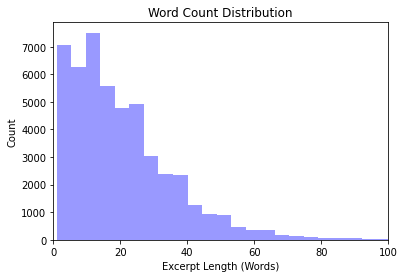

In [ ]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

In [ ]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 3
Max: 1803
Mean: 114.60138775510204
Median 94.0
1st percentile 6.990000000000009
95th percentile 284.0
99th percentile 421.01000000000204
99.5th Percentile 495.0
99.9th Percentile 696.0030000000115


<ipython-input-15-8e4bef13dec1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")


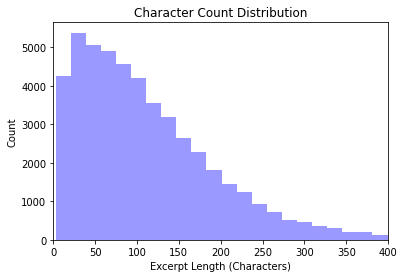

In [ ]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")


In [ ]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 2.25
Max: 54.0
Mean: 5.596575284913619
Median 5.5
1st percentile 4.0
95th percentile 7.0
99th percentile 9.0
99.5th Percentile 10.0
99.9th Percentile 13.0


<ipython-input-17-e0a359e7a16a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")


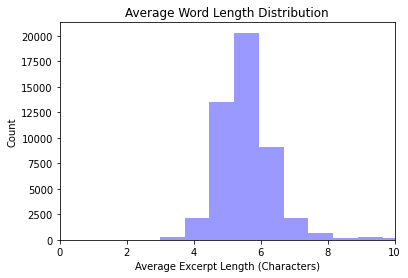

In [ ]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [ ]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 3513 - Length: 152
Salt, pepper, and sugar, must be put on the list; then flour in sack, oatmeal, cornmeal, rice, and lard; crackers, beans, coffee in tin, tea in bag, cocoa, condensed milk in cans, evaporated cream in cans, butter in pail, pickles, dried fruit in bags, a bag of potatoes, molasses, pork, boneless bacon, and, if you are fond of it, a few jars of orange marmalade; sal-soda for sweetening “dubs,” and ginger for medicinal purposes; several cakes of common soap for dish-washing, some dish-towels, and some soap for toilet purposes; also a tin coffee-pot, a long-handled frying-pan, a small griddle, a nest of tin pails, the smallest capable of holding a quart or less, and the largest a gallon or more; two or three paper pails or water-buckets, two or three iron kitchen spoons and forks, and a camp boiler, a firkin and a wooden spoon, also a strong axe and a hatchet. 

Excerpt 3751 - Length: 210
But why should we wonder at the general Love Gentlemen have for this Recrea

In [ ]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
  print("Excerpt {} - Length: {}".format(i, word_count[i]))
  print(text[i], "\n")

Excerpt 18 - Length: 1
"Neither. 

Excerpt 51 - Length: 1
-57 

Excerpt 81 - Length: 1
Motion.] 

Excerpt 161 - Length: 1
Crack! 

Excerpt 171 - Length: 1
-19 

Excerpt 187 - Length: 1
Itch. 

Excerpt 395 - Length: 1
Mlle. 

Excerpt 416 - Length: 1
“Why”! 

Excerpt 527 - Length: 1
mummy-cloth. 

Excerpt 620 - Length: 1
275-278. 

Excerpt 641 - Length: 1
Reason! 

Excerpt 674 - Length: 1
Extra! 

Excerpt 737 - Length: 1
“There”! 

Excerpt 751 - Length: 1
Anth. 

Excerpt 968 - Length: 1
Poverino! 

Excerpt 1062 - Length: 1
"Thanks". 

Excerpt 1108 - Length: 1
“Kickery-ki! 

Excerpt 1191 - Length: 1
"Huh?" 

Excerpt 1221 - Length: 1
“Huzza! 

Excerpt 1222 - Length: 1
Burgoo. 

Excerpt 1233 - Length: 1
Pricked. 

Excerpt 1237 - Length: 1
Amerik. 

Excerpt 1268 - Length: 1
Face-strap. 

Excerpt 1394 - Length: 1
Pole-Leaping. 

Excerpt 1402 - Length: 1
Kilogrammes. 

Excerpt 1429 - Length: 1
“What”! 

Excerpt 1441 - Length: 1
Ddsa”! 

Excerpt 1533 - Length: 1
"Ardita!" 

Excerpt 1564 - Lengt

In [ ]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 527 - Average Length: 12.0
mummy-cloth. 

Excerpt 1108 - Average Length: 12.0
“Kickery-ki! 

Excerpt 1268 - Average Length: 11.0
Face-strap. 

Excerpt 1394 - Average Length: 13.0
Pole-Leaping. 

Excerpt 1402 - Average Length: 12.0
Kilogrammes. 

Excerpt 1445 - Average Length: 13.0
[Illustration]     RIDING. 

Excerpt 1621 - Average Length: 11.0
[Illustration: Hembry. 

Excerpt 2673 - Average Length: 15.5
Timor                        58.7                    11.6   4. 

Excerpt 2732 - Average Length: 13.5
[Illustration: WALSINGHAM.] 

Excerpt 2829 - Average Length: 12.0
Mum-mum-mum. 

Excerpt 3461 - Average Length: 11.0
“Hoseason”! 

Excerpt 3642 - Average Length: 13.0
Bearing-rein. 

Excerpt 3647 - Average Length: 10.5
[Illustration: SOUTH WRAXALL MANOR-HOUSE.] 

Excerpt 4692 - Average Length: 11.5
[Illustration: RIPPLE.] 

Excerpt 5419 - Average Length: 10.5
“Hammersmiths’ what”? 

Excerpt 5452 - Average Length: 10.80952380952381
12345678          21436587   24153678   42513687

In [ ]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 51 - Average Length: 3.0
-57 

Excerpt 171 - Average Length: 3.0
-19 

Excerpt 505 - Average Length: 3.0
1 and 2.) 

Excerpt 1356 - Average Length: 3.25
C. of E. iii. 

Excerpt 1997 - Average Length: 2.5
A. J. 

Excerpt 2296 - Average Length: 2.5
J. R. 

Excerpt 2585 - Average Length: 3.0
See on i. 

Excerpt 2993 - Average Length: 3.0
'd it. 

Excerpt 3157 - Average Length: 2.5
8, 1. 

Excerpt 3721 - Average Length: 3.3333333333333335
See on iv. 

Excerpt 3847 - Average Length: 3.0
72, 4. 

Excerpt 4273 - Average Length: 3.0
3 and 4.) 

Excerpt 4379 - Average Length: 3.0
See on i. 

Excerpt 4425 - Average Length: 3.0
See on i. 

Excerpt 4455 - Average Length: 3.3333333333333335
He had to! 

Excerpt 5410 - Average Length: 3.3333333333333335
Here I am. 

Excerpt 5825 - Average Length: 3.0
-17 

Excerpt 5990 - Average Length: 3.3333333333333335
See on iv. 

Excerpt 6076 - Average Length: 3.3333333333333335
He had to! 

Excerpt 6138 - Average Length: 3.4285714285714284
The rope to 

In [ ]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 995318, 'e': 557298, 't': 411712, 'a': 355770, 'o': 334517, 'i': 304762, 'n': 304402, 's': 288237, 'h': 281446, 'r': 260290, 'l': 183113, 'd': 183004, 'u': 120613, 'c': 113395, 'm': 106650, 'f': 106144, 'w': 98088, 'g': 89789, 'y': 81607, ',': 76192, 'p': 75562, 'b': 70020, '.': 47365, 'v': 43390, 'k': 32348, '"': 10215, '-': 9022, ';': 8209, 'x': 7054, "'": 5462, 'j': 4871, 'q': 4563, '’': 4063, '“': 4001, '”': 3956, '!': 2787, 'z': 2778, '1': 2650, '(': 2393, '?': 2380, ':': 2363, ')': 2331, '2': 1799, '3': 1459, '4': 1292, '5': 1251, '6': 1223, '8': 958, '‘': 955, ']': 939, '[': 931, '*': 915, '0': 869, '7': 827, '—': 622, '9': 498, 'é': 157, '\xa0': 122, '&': 104, '=': 40, 'æ': 32, '{': 31, '}': 31, 'è': 29, '/': 21, 'à': 20, '–': 16, 'â': 15, '£': 15, 'ï': 14, '\ufeff': 14, 'ö': 13, '|': 13, 'ü': 11, '$': 11, 'ä': 10, 'ê': 8, 'ë': 7, 'á': 7, 'œ': 6, 'ç': 6, '½': 6, 'ô': 5, '„': 4, 'ñ': 4, 'ì': 4, '′': 4, '·': 2, '×': 2, 'ú': 2, 'ó': 2, 'û': 2, 'í': 1, '§': 1, 'ò': 1,

In [ ]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['“', 'o', 'h', ' ', 'n', ',', 'm', 'y', 'd', 'e', 'a', 'r', 'i', 's', 'l', 'u', 't', 'k', '.', 'v', 'g', 'b', 'w', 'f', 'p', "'", 'x', 'c', ':', '"', 'z', '!', 'j', ';', '”', 'q', '(', 'é', '’', '-', '?', '[', '1', ']', '5', '7', '8', ')', 'ï', '0', '3', '—', '9', '2', '6', '4', '‘', 'ô', '\ufeff', '*', '\xa0', 'ä', '&', 'ë', 'à', 'œ', '=', '„', 'ê', 'ñ', 'â', 'æ', 'ì', 'ö', 'ç', 'í', 'è', '§', '/', '′', 'ò', 'ü', '£', '½', '–', 'á', '$', '|', '·', 'î', '{', '}', '`', '×', 'ú', '°', '#', 'ó', 'û', '¾', '¼', '´']


In [ ]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë','€','œ','€™','€˜','*','/','{','}','Ã','Â']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print('There are', str(len(accented_text)), 'texts containing accented characters.')


There are 557 texts containing accented characters.


In [ ]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

Excerpt 32768
The weight of these varies from 2-1/3 to 3-1/2 lbs., and the length of the head and shape is a matter of individual fancy.

Excerpt 8200
*   * J. Gerard, Cornhill, 1692.

Excerpt 23
Someone hallooed to Rodvard from the stern of the ship; Demadé Slair was waiting there with Lalette, muffled close in her long cloak.

Excerpt 30744
*       *       *       *       *  It is Sunday morning.

Excerpt 16421
*       *       *       *       *  Two peasants in black-and-white are strolling in the sun, flashing.

Excerpt 38966
Lot Twenty-five Feet Wide  is usually one hundred feet deep; this will allow plenty of room for the house and the clothes-lines, and still leave the end of the lot for a famous back-yard zoölogical garden.

Excerpt 47159
*       *       *       *       *  Evening was falling, the sun declining.

Excerpt 10298
*       *       *       *       *  The landscape was different from yesterday's.

Excerpt 14404
Prior's "Notes on Croquet," published in 1872, the origin 

In [ ]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]
  

In [ ]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == accented_chars:
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [ ]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

49000


In [ ]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [ ]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['oh no oh no my dear demoiselle you must not mistake', 'some evenings i used to bring home two or three rabbits though oftener than not none at all but whatever the result it was all the same a very pleasant way of spending a summers evening and there was a good deal of excitement about it', 'elsewhere lowell has given another admirable definition sentiment is intellectualized emotion emotion precipitated as it were in pretty crystals of thought', 'so hoe', 'immediately after dinner he must resume his exercise by running half a mile at the top of his speed and walking six miles at a moderate pace']
49000


In [ ]:
text_train, text_test, genre_train,genre_test = train_test_split(normed_text, genre, test_size = 0.2, random_state = 5)

In [ ]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(genre_train))
print(np.shape(genre_test))

(39200,)
(9800,)
(39200,)
(9800,)


In [ ]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [ ]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences
    
    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [ ]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)


Vocab size for n = 1 is: 71
Vocab size for n = 2 is: 1509
Vocab size for n = 3 is: 14654


In [ ]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 71, 350)
gram2_train = create_n_grams(text_train, 2, 1509, 350)
gram3_train = create_n_grams(text_train, 3, 14654, 350)

gram1_test = create_n_grams(text_test, 1, 71, 350)
gram2_test = create_n_grams(text_test, 2, 1509, 350)
gram3_test = create_n_grams(text_test, 3, 14654, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(39200, 350)
(39200, 350)
(39200, 350)
(9800, 350)
(9800, 350)
(9800, 350)


In [ ]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  90
Maximum encoding value for 2-grams is:  1961
Maximum encoding value for 3-grams is:  19049


Create bag-of-words features

In [ ]:
def process_data(excerpt_list):
    """Stem data, remove stopwords and split into word lists
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    
    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [ ]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['latter progress extrem slow', 'sound appear come remot height somewher night', 'dark set complet saw although mother affect make light bessi protract absenc glanc uneasili time time window old dutch clock tick corner use tick boy rode father knee noth seem chang save mother older stoop trifl', 'dont know feel toward johnni', 'regist myonessa said lalett extend paper']


In [ ]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  6695


In [ ]:
# One hot encode labels
genre_lb = LabelBinarizer()

genre_lb.fit(genre_train)
genre_train_hot = genre_lb.transform(genre_train)
genre_test_hot = genre_lb.transform(genre_test)

In [ ]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [ ]:
# Create the 1-gram model
gram1_model = define_model(350, 7, max_1gram + 1, 26)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 350, 26)      2366        ['input_1[0][0]']                
                                                                                              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], genre_train_hot, epochs=7, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/7
980/980 [==============================] - 37s 28ms/step - loss: 1.8875 - accuracy: 0.2049 - val_loss: 1.8337 - val_accuracy: 0.2552
Epoch 2/7
980/980 [==============================] - 25s 26ms/step - loss: 1.7866 - accuracy: 0.2747 - val_loss: 1.7893 - val_accuracy: 0.2652
Epoch 3/7
980/980 [==============================] - 26s 27ms/step - loss: 1.7158 - accuracy: 0.3184 - val_loss: 1.7410 - val_accuracy: 0.2968
Epoch 4/7
980/980 [==============================] - 27s 28ms/step - loss: 1.6466 - accuracy: 0.3499 - val_loss: 1.7270 - val_accuracy: 0.3036
Epoch 5/7
980/980 [==============================] - 27s 28ms/step - loss: 1.5790 - accuracy: 0.3904 - val_loss: 1.7177 - val_accuracy: 0.3203
Epoch 6/7
980/980 [==============================] - 27s 27ms/step - loss: 1.5170 - accuracy: 0.4159 - val_loss: 1.7123 - val_accuracy: 0.3255
Epoch 7/7
980/980 [==============================] - 27s 27ms/step - loss: 1.4607 - accuracy: 0.4417 - val_loss: 1.7085 - val_accuracy: 0.3281

In [ ]:
# Create the 2-gram model
gram2_model = define_model(350, 7, max_2gram + 1, 300)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 350, 300)     588600      ['input_4[0][0]']                
                                                                                            

In [ ]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], genre_train_hot, epochs=7, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/7
980/980 [==============================] - 63s 62ms/step - loss: 1.8386 - accuracy: 0.2379 - val_loss: 1.7118 - val_accuracy: 0.3101
Epoch 2/7
980/980 [==============================] - 60s 61ms/step - loss: 1.5913 - accuracy: 0.3818 - val_loss: 1.5626 - val_accuracy: 0.3908
Epoch 3/7
980/980 [==============================] - 58s 59ms/step - loss: 1.3933 - accuracy: 0.4815 - val_loss: 1.5163 - val_accuracy: 0.4200
Epoch 4/7
980/980 [==============================] - 58s 59ms/step - loss: 1.2283 - accuracy: 0.5560 - val_loss: 1.4534 - val_accuracy: 0.4437
Epoch 5/7
980/980 [==============================] - 60s 61ms/step - loss: 1.0885 - accuracy: 0.6191 - val_loss: 1.4723 - val_accuracy: 0.4418
Epoch 6/7
980/980 [==============================] - 60s 61ms/step - loss: 0.9598 - accuracy: 0.6734 - val_loss: 1.4662 - val_accuracy: 0.4446
Epoch 7/7
980/980 [==============================] - 58s 59ms/step - loss: 0.8459 - accuracy: 0.7195 - val_loss: 1.4969 - val_accuracy: 0.4482

In [ ]:
from nltk import ngrams
n=3
word_n_grams= ngrams(excerpt.split(),n)
for wgrams in word_n_grams:
    print(wgrams)

('The', 'savage,', 'like')
('savage,', 'like', 'the')
('like', 'the', 'civilised')
('the', 'civilised', 'man,')
('civilised', 'man,', 'is')
('man,', 'is', 'curious.')


In [ ]:
# Create the 3-gram model
gram3_model = define_model(350, 7, max_3gram + 1, 600)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 350, 600)     11430000    ['input_7[0][0]']                
                                                                                            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], genre_train_hot, epochs=7, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/7
980/980 [==============================] - 100s 100ms/step - loss: 1.8142 - accuracy: 0.2531 - val_loss: 1.5811 - val_accuracy: 0.3676
Epoch 2/7
980/980 [==============================] - 98s 100ms/step - loss: 1.3395 - accuracy: 0.5035 - val_loss: 1.2989 - val_accuracy: 0.5152
Epoch 3/7
980/980 [==============================] - 97s 99ms/step - loss: 0.9948 - accuracy: 0.6503 - val_loss: 1.2157 - val_accuracy: 0.5520
Epoch 4/7
980/980 [==============================] - 97s 99ms/step - loss: 0.7494 - accuracy: 0.7507 - val_loss: 1.2043 - val_accuracy: 0.5699
Epoch 5/7
980/980 [==============================] - 97s 99ms/step - loss: 0.5617 - accuracy: 0.8261 - val_loss: 1.2514 - val_accuracy: 0.5666
Epoch 6/7
980/980 [==============================] - 102s 104ms/step - loss: 0.4072 - accuracy: 0.8845 - val_loss: 1.3247 - val_accuracy: 0.5689
Epoch 7/7
980/980 [==============================] - 97s 99ms/step - loss: 0.2883 - accuracy: 0.9268 - val_loss: 1.4367 - val_accuracy: 0

Fit the SVM


In [ ]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [ ]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, genre_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=1, kernel=linear..........................................
[CV 1/5; 1/3] END ...........C=1, kernel=linear;, score=0.602 total time= 1.9min
[CV 2/5; 1/3] START C=1, kernel=linear..........................................
[CV 2/5; 1/3] END ...........C=1, kernel=linear;, score=0.605 total time= 1.9min
[CV 3/5; 1/3] START C=1, kernel=linear..........................................
[CV 3/5; 1/3] END ...........C=1, kernel=linear;, score=0.605 total time= 1.9min
[CV 4/5; 1/3] START C=1, kernel=linear..........................................
[CV 4/5; 1/3] END ...........C=1, kernel=linear;, score=0.604 total time= 1.9min
[CV 5/5; 1/3] START C=1, kernel=linear..........................................
[CV 5/5; 1/3] END ...........C=1, kernel=linear;, score=0.608 total time= 1.9min
[CV 1/5; 2/3] START C=10, kernel=linear.........................................
[CV 1/5; 2/3] END ..........C=10, kernel=linear;,

In [ ]:
print(word_svm.best_estimator_)

SVC(C=1, kernel='linear')


In [ ]:
print(word_svm.cv_results_)

{'mean_fit_time': array([ 98.57169843, 118.89703951, 252.70902009]), 'std_fit_time': array([1.3707803 , 1.33556586, 5.60333003]), 'mean_score_time': array([15.3203229 , 14.19692187, 13.85241652]), 'std_score_time': array([0.34114877, 0.34624925, 0.10632986]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.60153061, 0.55867347, 0.51811224]), 'split1_test_score': array([0.60535714, 0.56415816, 0.5244898 ]), 'split2_test_score': array([0.60548469, 0.56989796, 0.52716837]), 'split3_test_score': array([0.60433673, 0.5622449 , 0.52372449]), 'split4_test_score': array([0.60816327, 0.56760204, 0.52691327]), 'mean_test_sco

Refinement

In [ ]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
        # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
        # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [ ]:
# Create the 3-gram model
gram3_model2 = define_model2(350, 7, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 350)]        0           []                               
                                                                                            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], genre_train_hot, epochs=7, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/7
980/980 [==============================] - 139s 140ms/step - loss: 1.8016 - accuracy: 0.2582 - val_loss: 1.5529 - val_accuracy: 0.3776
Epoch 2/7
980/980 [==============================] - 133s 136ms/step - loss: 1.2841 - accuracy: 0.5296 - val_loss: 1.2729 - val_accuracy: 0.5298
Epoch 3/7
980/980 [==============================] - 134s 136ms/step - loss: 0.9208 - accuracy: 0.6806 - val_loss: 1.2202 - val_accuracy: 0.5543
Epoch 4/7
980/980 [==============================] - 136s 139ms/step - loss: 0.6622 - accuracy: 0.7841 - val_loss: 1.2322 - val_accuracy: 0.5611
Epoch 5/7
980/980 [==============================] - 136s 139ms/step - loss: 0.4631 - accuracy: 0.8651 - val_loss: 1.2953 - val_accuracy: 0.5617
Epoch 6/7
980/980 [==============================] - 136s 139ms/step - loss: 0.3090 - accuracy: 0.9221 - val_loss: 1.3596 - val_accuracy: 0.5639
Epoch 7/7
980/980 [==============================] - 133s 136ms/step - loss: 0.2023 - accuracy: 0.9561 - val_loss: 1.5055 - val_ac

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
    cm: matrix. Confusion matrix for plotting.
    classes: list. List of class labels.
    normalize: bool. Whether or not to normalize the confusion matrix.
    title: string. Title for plot.
    cmap: color map. Color scheme for plot.
    
    Returns:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [ ]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 7, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], genre_train_hot, epochs=7, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
genre_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
genre_pred1 = genre_lb.inverse_transform(genre_pred1)

# Evaluate
accuracy = accuracy_score(genre_test, genre_pred1)
precision, recall, f1, support = score(genre_test,genre_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix (genre_test, genre_pred1, labels = ['Childrens','Literature','Religion','Romantic','Sciencefic' ,'Sports','Travel' ])
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 350, 600)     11430000    ['input_17[0][0]']               
                                                                                            

Normalized confusion matrix
[[0.64735336 0.07367668 0.02503577 0.03433476 0.08941345 0.04077253
  0.08941345]
 [0.16689751 0.34764543 0.03185596 0.07756233 0.17936288 0.05193906
  0.14473684]
 [0.04151493 0.01310998 0.61544064 0.10050983 0.0386016  0.08011653
  0.11070648]
 [0.05625879 0.03164557 0.10759494 0.55555556 0.0443038  0.0766526
  0.12798875]
 [0.11535581 0.09138577 0.04719101 0.06067416 0.45842697 0.082397
  0.14456929]
 [0.03006993 0.00769231 0.03846154 0.06013986 0.03356643 0.74685315
  0.08321678]
 [0.08941345 0.05007153 0.09298999 0.09155937 0.08869814 0.11015737
  0.47711016]]


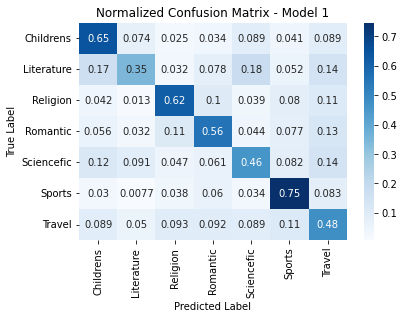

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Childrens','Literature','Religion','Romantic','Sciencefic' ,'Sports','Travel'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

In [ ]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, genre_train)

t1 = time.time()

# Predict values for test set
author_pred2 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(genre_test, genre_pred1)
precision, recall, f1, support = score(genre_test, genre_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(genre_test, author_pred2, labels =  ['Childrens','Literature','Religion','Romantic','Sciencefic' ,'Sports','Travel'])

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.5498979591836735
Ave. Precision: 0.5527568714517707
Ave. Recall: 0.5498979591836733
Ave. F1 Score: 0.5455945765245195
Training Time: 140.92193007469177 seconds
Prediction Time: 21.476521253585815 seconds
Confusion Matrix:
 [[ 913  193   41   52   95   40   64]
 [ 129  801   55   90  181   52  136]
 [  48   99  949  101   62   30   84]
 [  73  166  149  842   60   33   99]
 [  66  239   73   54  753   45  105]
 [  35  106   52   48   62 1043   84]
 [  86  226  104   88  126   72  696]]


Normalized confusion matrix
[[0.65307582 0.13805436 0.02932761 0.03719599 0.06795422 0.0286123
  0.04577969]
 [0.08933518 0.55470914 0.03808864 0.06232687 0.12534626 0.03601108
  0.09418283]
 [0.03495994 0.07210488 0.69118718 0.07356154 0.04515659 0.02184996
  0.0611799 ]
 [0.05133615 0.11673699 0.104782   0.59212377 0.04219409 0.02320675
  0.06962025]
 [0.0494382  0.17902622 0.05468165 0.04044944 0.56404494 0.03370787
  0.07865169]
 [0.02447552 0.07412587 0.03636364 0.03356643 0.04335664 0.72937063
  0.05874126]
 [0.06151645 0.16165951 0.07439199 0.06294707 0.09012876 0.05150215
  0.49785408]]


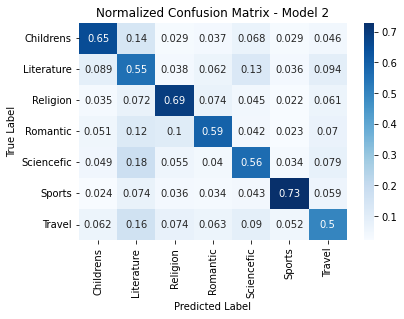

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Childrens','Literature','Religion','Romantic','Sciencefic' ,'Sports','Travel'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")

In [ ]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0


for train_inds, _ in kf.split(gram3_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([genre_train_hot[i] for i in train_inds])
       
    # Fit model
    model1 = define_model(350, 7, max_3gram + 1, 600, verbose = False)
    model1.fit([gram3_train, gram3_train, gram3_train], genre_train_hot, epochs=7, batch_size=32, verbose = 0)
    
    # Predict values for test set
    genre_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
    genre_pred1 = genre_lb.inverse_transform(genre_pred1)

    # Evaluate
    accuracy = accuracy_score(genre_test, genre_pred1)
    precision, recall, f1, support = score(genre_test, genre_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 7s 22ms/step
Run: 2


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 7s 22ms/step
Run: 3


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


307/307 [==============================] - 7s 22ms/step
Accuracy: [0.5583673469387755, 0.558265306122449, 0.5513265306122449]
Ave. Precision: [0.5568319143416828, 0.5570372358120207, 0.5561663784732835]
Ave. Recall: [0.5583673469387755, 0.558265306122449, 0.5513265306122448]
Ave. F1 Score: [0.5556885001281484, 0.5553547231406659, 0.549544006021245]


In [ ]:
def calculate_averages(true, pred, text):
    """Calculate average length of correctly and incorrectly classified examples
    
    Args:
    true: list. List of correct labels.
    pred: list. List of predicted labels.
    text: list. List of text excerpts.
    
    Returns:
    correct_ave_chars: float. Average length of correctly classified examples in characters.
    incorrect_ave_chars: float. Average length of incorrectly classified examples in characters.
    correct_ave_words: float. Average length of correctly classified examples in characters.
    incorrect_ave_words: float. Average length of incorrectly classified examples in characters.
    """
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    # Conduct two sample t-test
    print('Character t-test')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nWord t-test')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [ ]:
# Calculate averages for Model 1
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(genre_test, genre_pred1, text_test)

Character t-test
Ttest_indResult(statistic=11.638331942797857, pvalue=4.2265841408469326e-31)

Word t-test
Ttest_indResult(statistic=11.312738801110532, pvalue=1.7330966368007064e-29)


In [ ]:
# Calculate averages for Model 2
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(genre_test, genre_pred1, text_test)

Character t-test
Ttest_indResult(statistic=11.638331942797857, pvalue=4.2265841408469326e-31)

Word t-test
Ttest_indResult(statistic=11.312738801110532, pvalue=1.7330966368007064e-29)


In [ ]:
print('Model 1 - Average excerpt length (chars) of correct examples =', correct_ave_chars1, 
        'Incorrect exampes =', incorrect_ave_chars1)
print('Model 2 - Average excerpt length (chars) of correct examples =', correct_ave_chars2, 
      'Incorrect exampes =', incorrect_ave_chars2)

print('\nModel 1 - Average excerpt length (words) of correct examples =', correct_ave_words1, 
        'Incorrect exampes =', incorrect_ave_words1)
print('Model 2 - Average excerpt length (words) of correct examples =', correct_ave_words2, 
      'Incorrect exampes =', incorrect_ave_words2)

Model 1 - Average excerpt length (chars) of correct examples = 118.92411623172312 Incorrect exampes = 98.21014327950876
Model 2 - Average excerpt length (chars) of correct examples = 118.92411623172312 Incorrect exampes = 98.21014327950876

Model 1 - Average excerpt length (words) of correct examples = 22.183601702757727 Incorrect exampes = 18.486013190811917
Model 2 - Average excerpt length (words) of correct examples = 22.183601702757727 Incorrect exampes = 18.486013190811917
